In [1]:
# Import libraries
import moments, moments.LD
import pandas as pd, numpy as np
from collections import defaultdict
import demes, demesdraw, matplotlib.pylab as plt
import msprime as ms

import model, slice, get_LD, plot_LD

##### Functions

In [2]:
def plot_iicr(iirc,T): 
    plt.step(T, iirc)
    plt.xticks(fontsize= 12)
    plt.yticks(fontsize= 12)
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("time ago (years)",fontsize = 14)
    plt.ylabel(r"IICR",fontsize = 14);

In [9]:
def plot_comparison(LDpop1,LDpop2,labels=["Original","Size Change"]):
    rhos = np.logspace(-2, 2, 21)
    
    # plot D2
    f = plt.figure(figsize=(10,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)

    ax.plot(rhos,LDpop1[:,0],label=labels[0])
    ax.plot(rhos,LDpop2[:,0],label=labels[1])
    ax.legend()
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel(r"$\sigma_d^2$")
    ax.set_xlabel(r"$\rho$")

    # plot DZ
    ax2.plot(rhos,LDpop1[:,1],label=labels[0])
    ax2.plot(rhos,LDpop2[:,1],label=labels[1])
    ax2.legend()
    ax2.set_yscale("log")
    ax2.set_xscale("log")
    ax2.set_ylabel(r"$\sigma_{Dz}$")
    ax2.set_xlabel(r"$\rho$")

    plt.tight_layout()
    plt.show()

In [8]:

def get_N_times_from_iicr(iicr,T):
    """
    Takes an the inverse inferred rate of coalescence and the time points and returns the times at which size changes.
    """
    previous_N = 0
    Ns = []
    times = []  
    for N,time in zip(iicr,T):
        if int(N) != int(previous_N):
            Ns.append(int(N))
            times.append(time)
            previous_N = int(N)

    return np.flip(Ns),np.flip(times)

def size_change_from_iicr(iicr,T,yaml_filename=None,plot=True,plot_filename=None,time_units="years",generation_time=29):
    """
    Takes a vector of Ns in form of iicr and T times to create a model
    """
    if time_units == "generations":
        generation_time=1

    Ns,times = get_N_times_from_iicr(iicr,T)
    
    m = demes.Builder(time_units=time_units,generation_time=generation_time)

    #current_time=np.array(time_period).sum()

    epochs = []
    for N,time in zip(Ns,times):
        epoch = dict(start_size=N,end_time=time)
        epochs.append(epoch)

    m.add_deme("Deme",epochs=epochs)

    # Resolve model
    graph = m.resolve()
    # option to save to yaml
    if yaml_filename != None:
        demes.dump(graph, yaml_filename, format='yaml', simplified=True)
    
    if plot:
        p = demesdraw.tubes(graph, log_time=True, num_lines_per_migration=3)
        if plot_filename != None:
            p.figure.savefig(plot_filename+".pdf")
    
    return graph  
    

In [7]:
def size_change(Ns,time_period,yaml_filename=None,plot=True,plot_filename=None,time_units="years",generation_time=29):
    
    if time_units == "generations":
        generation_time=1

    m = demes.Builder(time_units=time_units,generation_time=generation_time)
    current_time=np.array(time_period).sum()

    epochs = []
    for N,time in zip(Ns,time_period):
        epoch = dict(start_size=N,end_time=current_time-time)
        current_time=current_time-time
        epochs.append(epoch)

    m.add_deme("Deme",epochs=epochs)

    # Resolve model
    graph = m.resolve()

    # Check demographic events
    print(epochs)
    
    # option to save to yaml
    if yaml_filename != None:
        demes.dump(graph, yaml_filename, format='yaml', simplified=True)
    
    if plot:
        p = demesdraw.tubes(graph, log_time=True, num_lines_per_migration=3)
        if plot_filename != None:
            p.figure.savefig(plot_filename+".pdf")
    
    return graph 

def get_crt_croosspop(demes_model,pop1,pop2,T):
    """
    Returns two arrays: the Coalescence rate and the Inferred Inverse Coalescence Rate (Popsize)
    """
    m = ms.Demography.from_demes(demes_model)
    debug = m.debug()
    R, P = debug.coalescence_rate_trajectory(T, {pop1: 2,pop2: 2})
    inversed_R = 1/(2*R)

    return R,inversed_R,P,T

In [12]:
def run_LD_analysis_from_model(Demes_model,time_units="generations",generation_time=1,pop="Merge_1"):
    # Sample times at epochs
    T,_ = slice.sample_timepoints(Demes_model,anc_end_time=1e6/29)
    # Compute LD 
    model_sliced = slice.slice_timepoints(Demes_model,time_points=[0])
    model_sliced_LD = get_LD.get_LD_from_sliced_demes(model_sliced)
    # Get IIRC
    if time_units == "years":
        time_iicr=T/29
    else:
        time_iicr=T
    _, model_iicr, _ = model.get_iicr(Demes_model,pop=pop,T=time_iicr)
    plot_iicr(model_iicr,T)
    
    model_sc = size_change_from_iicr(model_iicr,T,time_units=time_units,generation_time=generation_time,plot=True)
    # Slice the generated model and get LD
    model_sc_sliced = slice.slice_timepoints(model_sc,time_points=[0])
    model_sc_sliced_LD = get_LD.get_LD_from_sliced_demes(model_sc_sliced)
    # Get signal magnitude
    x = model_sliced_LD[pop][-1] # Model
    y = model_sc_sliced_LD['Deme'][-1] # size change
    plot_comparison(x,y)
    
    return model_iicr, time_iicr, model_sc, model_sliced_LD

def run_LD_analysis_from_model_crosspop(Demes_model,time_units="generations",generation_time=1,pops=["Split_00","Split_01"]):
    # Sample times at epochs
    T,_ = slice.sample_timepoints(Demes_model,anc_end_time=1e6/29)
    # Compute LD 
    model_sliced = slice.slice_timepoints(Demes_model,time_points=[0])
    model_sliced_LD = get_LD.get_LD_from_sliced_demes(model_sliced)
    # Get IIRC
    if time_units == "years":
        time_iicr=T/29
    else:
        time_iicr=T
    print(time_iicr)
    _, model_iicr, _ , _ = get_crt_croosspop(Demes_model,pops[0],pops[1],T=time_iicr)
    plot_iicr(model_iicr,T)
    
    model_sc = size_change_from_iicr(model_iicr,T,time_units=time_units,generation_time=generation_time,plot=True)
    # Slice the generated model and get LD
    model_sc_sliced = slice.slice_timepoints(model_sc,time_points=[0])
    model_sc_sliced_LD = get_LD.get_LD_from_sliced_demes(model_sc_sliced)
    # Get signal magnitude
    x = model_sliced_LD[pops[0]][-1] # Model
    y = model_sc_sliced_LD['Deme'][-1] # size change
    plot_comparison(x,y)
    
    return model_iicr, time_iicr, model_sc, model_sliced_LD

##### Arguments for models

In [4]:
N = 20e3
time_period = 0.1*N

##### 1. Constant population

<AxesSubplot:ylabel='time ago (generations)'>

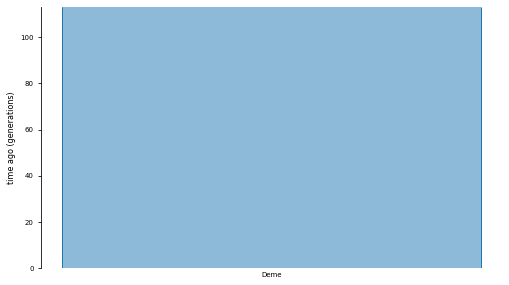

In [8]:
constant = demes.Builder()
constant.add_deme("Deme",epochs=[dict(start_size=N)])
graph = constant.resolve()
demesdraw.tubes(graph, log_time=False, num_lines_per_migration=3)

In [9]:
T,times_dic = slice.sample_timepoints(graph)

In [10]:
# Compute LD 
c_sliced = slice.slice_timepoints(graph,time_points=[0])
c_sliced_LD = get_LD.get_LD_from_sliced_demes(c_sliced)

In [11]:
c_R, c_iicr, _ = model.get_iicr(graph,pop="Deme",T=T)
c_sc = model.size_change_from_iicr(c_iicr,T,time_units="generations",plot=False)

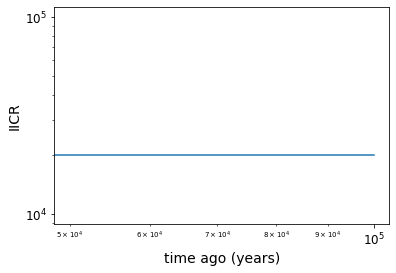

In [12]:
plot_iicr(c_iicr,T)

In [13]:
# Actually slice
c_sc_sliced = slice.slice_timepoints(c_sc,time_points=[0])
c_sc_sliced_LD = get_LD.get_LD_from_sliced_demes(c_sc_sliced)

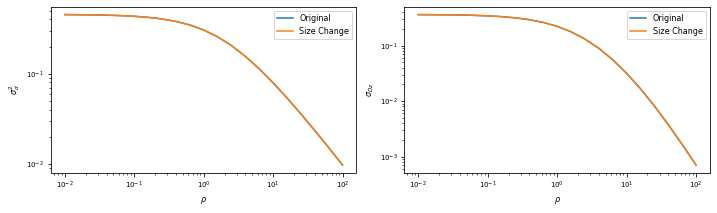

In [14]:
plot_comparison(c_sliced_LD['Deme'][-1],c_sc_sliced_LD['Deme'][-1])

##### 2. Size change - No structure

[{'start_size': 20000.0, 'end_time': 4000.0}, {'start_size': 2000.0, 'end_time': 1000.0}, {'start_size': 10000.0, 'end_time': 0.0}]


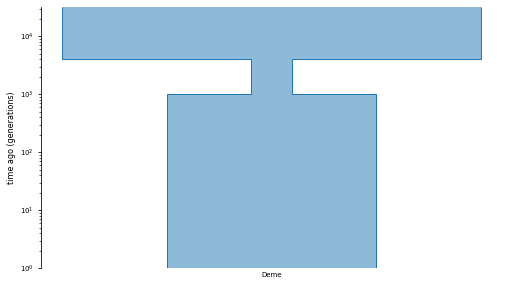

In [ ]:
sc_model = size_change(Ns=[N,N/10,N/2],time_period=[time_period,time_period*1.5,time_period/2],time_units="generations",yaml_filename="Model1.Size_change_NS.yaml")

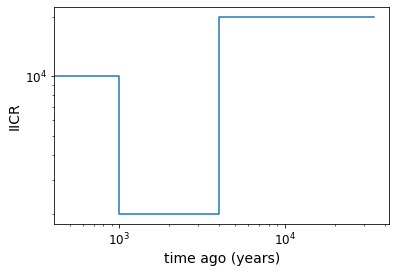

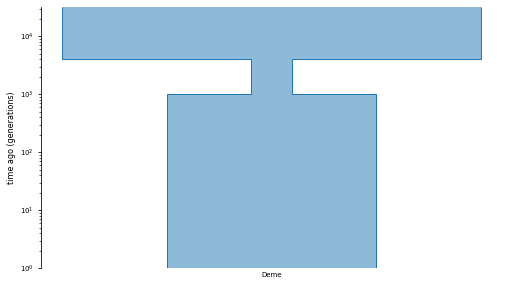

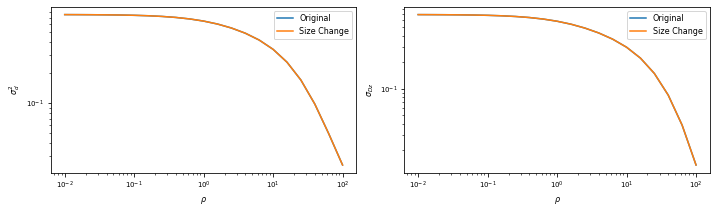

In [ ]:
model_iicr, time_iicr, model_sc, model_sliced_LD = run_LD_analysis_from_model(sc_model,pop="Deme")

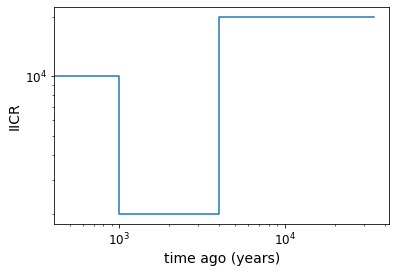

In [ ]:
plot_iicr(model_iicr,time_iicr)
plt.savefig("Model1.Size_change_NS.pdf",format="pdf")

In [ ]:
command = "./ms " + demes.to_ms(model_sc,N0=N)
command

'./ms -n 1 0.5 -en 0.0125 1 0.1 -en 0.05 1 1.0'

In [ ]:
"\t".join(map(str,time_iicr))

'0.0\t500.0\t999.0\t1000.0\t2500.0\t3999.0\t4000.0\t19241.379310344826\t34481.75862068965'

In [ ]:
file1 = open("Model1.Size_change_NS.mscommand", "w")
file1.write(command)
file1.close()

file1 = open("Model1.Size_change_NS.iicr", "w")
file1.write("\t".join(map(str,time_iicr)))
file1.write("\n")
file1.write("\t".join(map(str,model_iicr)))
file1.close()

##### 2. Size change - No structure

[{'start_size': 11500.0, 'end_time': 10000.0}, {'start_size': 1150.0, 'end_time': 7000.0}, {'start_size': 5750.0, 'end_time': 6000.0}, {'start_size': 1916.6666666666667, 'end_time': 4000.0}, {'start_size': 23000.0, 'end_time': 1000.0}, {'start_size': 1150.0, 'end_time': 0.0}]


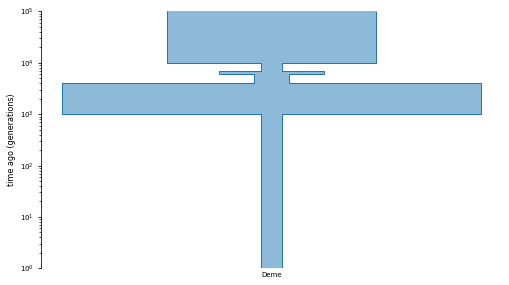

In [23]:
sc_model = size_change(Ns=[N,N/10,N/2,N/6,2*N,N/10],time_period=[time_period,time_period*1.5,time_period/2,time_period,time_period*1.5,time_period/2],time_units="generations",yaml_filename="Model1.Size_change_NS.yaml")

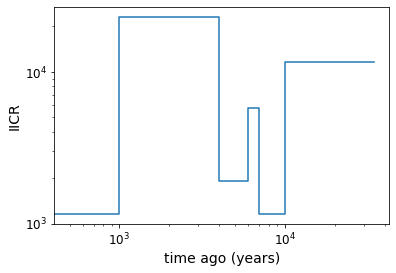

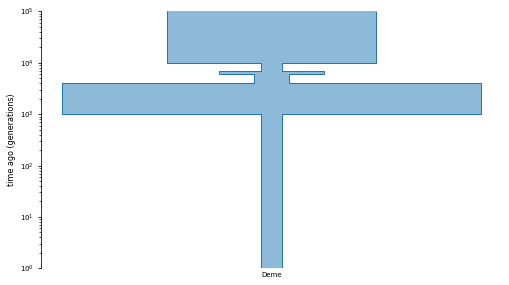

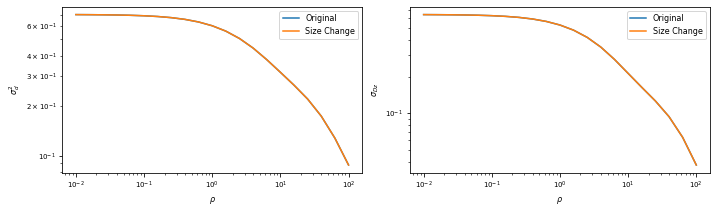

In [24]:
model_iicr, time_iicr, model_sc, model_sliced_LD = run_LD_analysis_from_model(sc_model,pop="Deme")

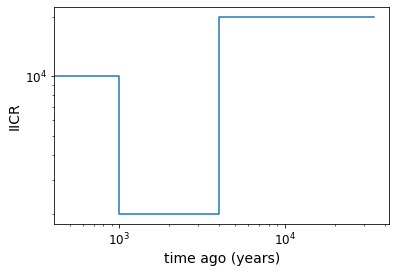

In [38]:
plot_iicr(model_iicr,time_iicr)
plt.savefig("Model1.Size_change_NS.pdf",format="pdf")

In [25]:
command = "./ms " + demes.to_ms(model_sc,N0=N)
command

'./ms -n 1 0.1 -en 0.021717391304347827 1 0.09991304347826087 -en 0.021739130434782608 1 2.0 -en 0.08695652173913043 1 0.1666086956521739 -en 0.13043478260869565 1 0.5 -en 0.15217391304347827 1 0.1 -en 0.21739130434782608 1 1.0'

In [26]:
"\t".join(map(str,time_iicr))

'0.0\t500.0\t999.0\t1000.0\t2500.0\t3999.0\t4000.0\t5000.0\t5999.0\t6000.0\t6500.0\t6999.0\t7000.0\t8500.0\t9999.0\t10000.0\t22241.379310344826\t34481.75862068965'

In [27]:
file1 = open("Model8.Size_change_NS.mscommand", "w")
file1.write(command)
file1.close()

file1 = open("Model8.Size_change_NS.iicr", "w")
file1.write("\t".join(map(str,time_iicr)))
file1.write("\n")
file1.write("\t".join(map(str,model_iicr)))
file1.close()

##### 3. Bubble, inspired from Mende

[Split(parent='Ancestral', children=['Split_01', 'Split_00'], time=3448.0)]


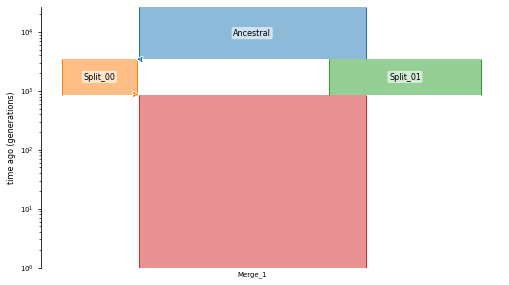

In [ ]:
alpha1=[0.33,0.67]
alpha2=[0.819,0.181]
N=11.5e3

generation_time=29
time_period_merge_yrs =[1e6,25e3]
time_period_merge_gen = np.round(np.array(time_period_merge_yrs)/generation_time)
time_period_splits_yrs=[75e3]
time_period_splits_gen=np.round(np.array(time_period_splits_yrs)/generation_time)

bubble = model.cake_model(Ns=[N,N],splits=[2],alpha1=[alpha1],alpha2=[alpha2],time_period_merge=time_period_merge_gen,time_period_splits=time_period_splits_gen,migration_rate=0,time_units="generations",generation_time=1,plot=True)


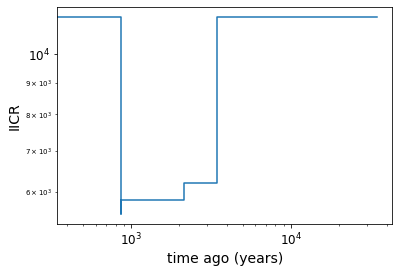

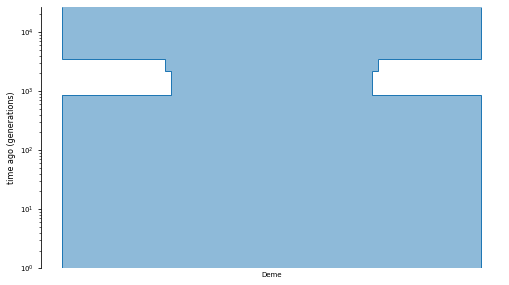

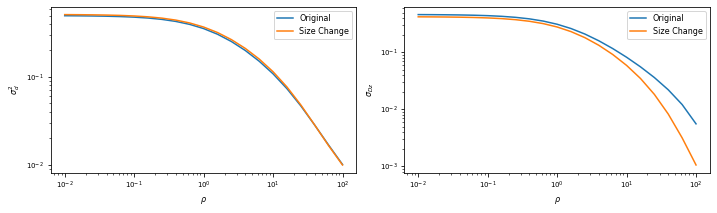

In [ ]:
model_iicr, time_iicr, model_sc, model_sliced_LD = run_LD_analysis_from_model(bubble)

In [ ]:
command = "./ms " + demes.to_ms(model_sc,N0=N)
command

'./ms -en 0.01873913043478261 1 0.48034782608695653 -en 0.04684782608695652 1 0.5072173913043478 -en 0.07493478260869565 1 0.5387826086956522 -en 0.07495652173913044 1 1.0'

In [ ]:
file1 = open("Model2.bubble_asymm_nm.mscommand", "w")
file1.write(command)
file1.close()

file1 = open("Model2.bubble_asymm_nm.iicr", "w")
file1.write("\t".join(map(str,time_iicr)))
file1.write("\n")
file1.write("\t".join(map(str,model_iicr)))
file1.close()

##### 3. Bubble, inspired from Mende with Migration

[Split(parent='Ancestral', children=['Split_01', 'Split_00'], time=3448.0)]


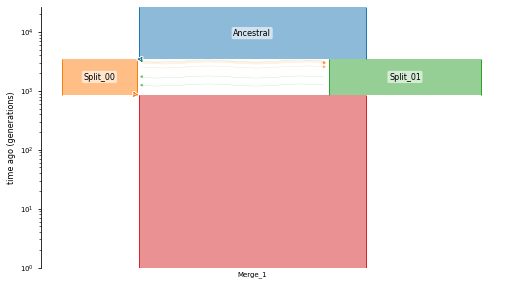

In [16]:
alpha1=[0.33,0.67]
alpha2=[0.819,0.181]
N=11.5e3

mg_rate = 19.8e-5
generation_time=29
time_period_merge_yrs =[1e6,25e3]
time_period_merge_gen = np.round(np.array(time_period_merge_yrs)/generation_time)
time_period_splits_yrs=[75e3]
time_period_splits_gen=np.round(np.array(time_period_splits_yrs)/generation_time)

bubble = model.cake_model(Ns=[N,N],splits=[2],alpha1=[alpha1],alpha2=[alpha2],time_period_merge=time_period_merge_gen,time_period_splits=time_period_splits_gen,migration_rate=mg_rate,time_units="generations",generation_time=1,plot=True)


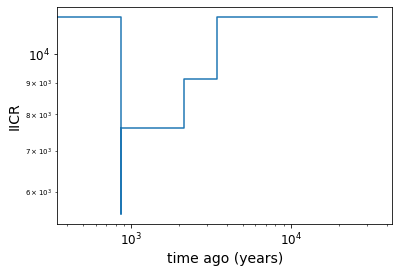

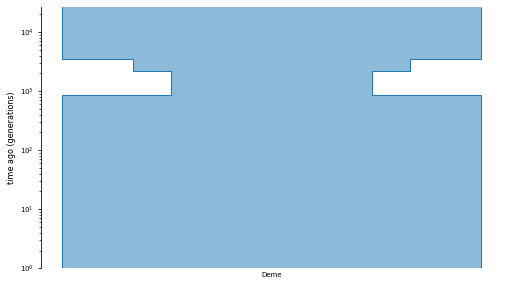

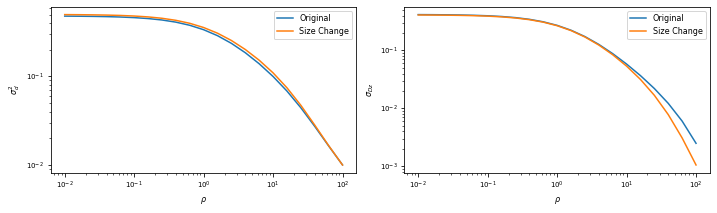

In [17]:
model_iicr, time_iicr, model_sc, model_sliced_LD = run_LD_analysis_from_model(bubble)

In [18]:
command = "./ms " + demes.to_ms(model_sc,N0=N)
command

'./ms -en 0.01873913043478261 1 0.48034782608695653 -en 0.04684782608695652 1 0.6611304347826087 -en 0.07493478260869565 1 0.7938260869565218 -en 0.07495652173913044 1 1.0'

In [19]:
file1 = open("Model7.bubble_asymm_m.mscommand", "w")
file1.write(command)
file1.close()

file1 = open("Model7.bubble_asymm_m.iicr", "w")
file1.write("\t".join(map(str,time_iicr)))
file1.write("\n")
file1.write("\t".join(map(str,model_iicr)))
file1.close()

##### 4. Bubble, symmetric alpha, no migration

[Split(parent='Ancestral', children=['Split_01', 'Split_00'], time=3448.0)]


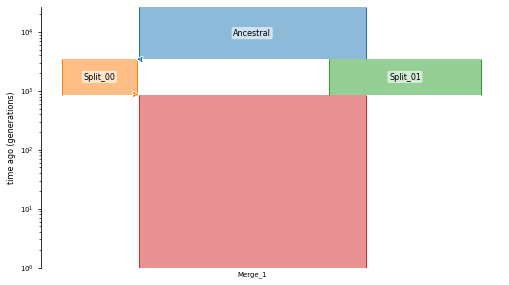

In [24]:
alpha1=[0.33,0.67]
alpha2=[0.33,0.67]
N=11.5e3

generation_time=29
time_period_merge_yrs =[1e6,25e3]
time_period_merge_gen = np.round(np.array(time_period_merge_yrs)/generation_time)
time_period_splits_yrs=[75e3]
time_period_splits_gen=np.round(np.array(time_period_splits_yrs)/generation_time)

bubble = model.cake_model(Ns=[N,N],splits=[2],alpha1=[alpha1],alpha2=[alpha2],time_period_merge=time_period_merge_gen,time_period_splits=time_period_splits_gen,migration_rate=0,time_units="generations",generation_time=1,plot=True,yaml_filename="Bubble_symmetric_alpha-Mende.yaml")


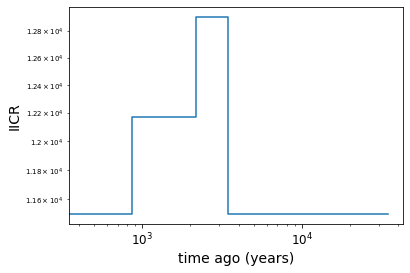

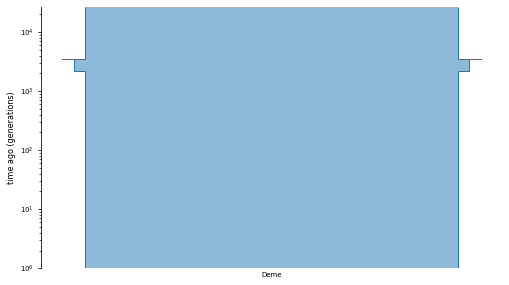

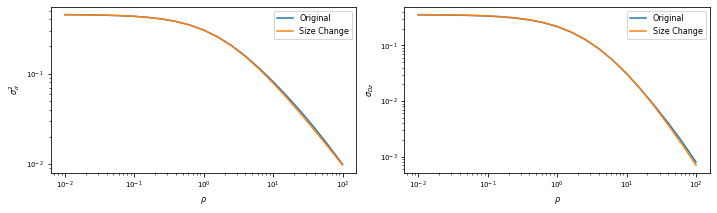

In [25]:
model_iicr, time_iicr, model_sc, model_sliced_LD = run_LD_analysis_from_model(bubble)

In [26]:
command = "./ms " + demes.to_ms(model_sc,N0=N)
command

'./ms -en 0.01873913043478261 1 0.9999130434782608 -en 0.04684782608695652 1 1.0586086956521739 -en 0.07493478260869565 1 1.1221739130434782 -en 0.07495652173913044 1 0.9999130434782608'

In [27]:
file1 = open("Model3.bubble_symm_nm.mscommand", "w")
file1.write(command)
file1.close()

file1 = open("Model3.bubble_symm_nm.iicr", "w")
file1.write("\t".join(map(str,time_iicr)))
file1.write("\n")
file1.write("\t".join(map(str,model_iicr)))
file1.close()

##### 5. Isolation with Migration model

<AxesSubplot:ylabel='time ago (generations)'>

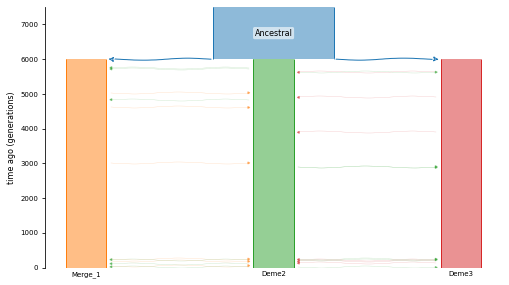

In [5]:
N=20e3
migration_rate1=1.7e-5
migration_rate2=2.2e-3

# Check def of migration rate in Demes, N*u of order 1

m = demes.Builder(time_units="generations")

#  Add first Ancestor
m.add_deme("Ancestral",epochs=[dict(start_size=N, end_time=N*0.3)])

m.add_deme("Merge_1",ancestors=["Ancestral"],epochs=[dict(start_size=N/3)])
m.add_deme("Deme2",ancestors=["Ancestral"],epochs=[dict(start_size=N/3)])
m.add_deme("Deme3",ancestors=["Ancestral"],epochs=[dict(start_size=N/3)])

m.add_migration(demes = ["Merge_1","Deme2"], rate = migration_rate1, end_time=2500)
m.add_migration(demes = ["Deme3","Deme2"], rate = migration_rate1, end_time=2500)

m.add_migration(demes = ["Merge_1","Deme2"], rate = migration_rate2, start_time=time_period/6, end_time=1)
m.add_migration(demes = ["Deme3","Deme2"], rate = migration_rate2, start_time=time_period/6 ,end_time=1)

IM = m.resolve()
demesdraw.tubes(IM, log_time=False, num_lines_per_migration=3)

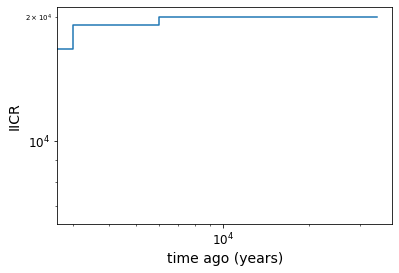

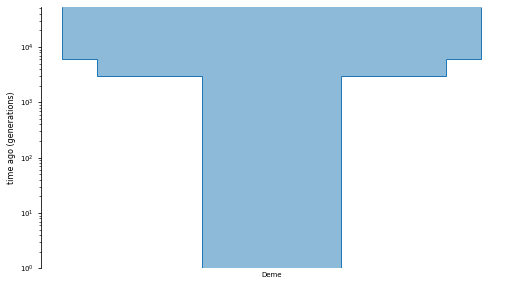

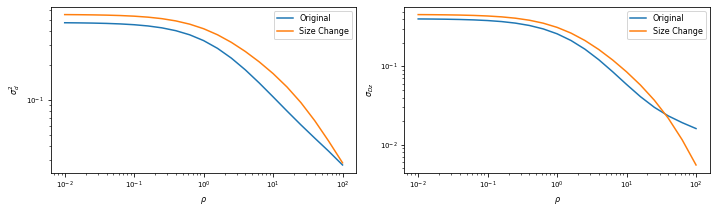

In [13]:
model_iicr, time_iicr, model_sc, model_sliced_LD = run_LD_analysis_from_model(IM, pop = "Merge_1")

In [30]:
command = "./ms " + demes.to_ms(model_sc,N0=N)
command

'./ms -n 1 0.3333 -en 0.0375 1 0.834 -en 0.0749875 1 0.95505 -en 0.075 1 1.0'

In [31]:
file1 = open("Model4.IM_cm.mscommand", "w")
file1.write(command)
file1.close()

file1 = open("Model4.IM_cm.iicr", "w")
file1.write("\t".join(map(str,time_iicr)))
file1.write("\n")
file1.write("\t".join(map(str,model_iicr)))
file1.close()

[    0.          3000.          5999.          6000.
 20241.37931034 34481.75862069]


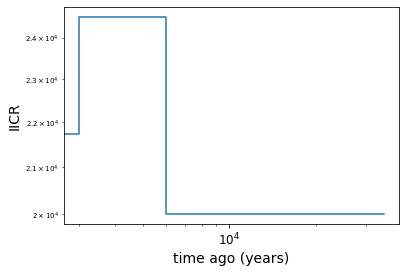

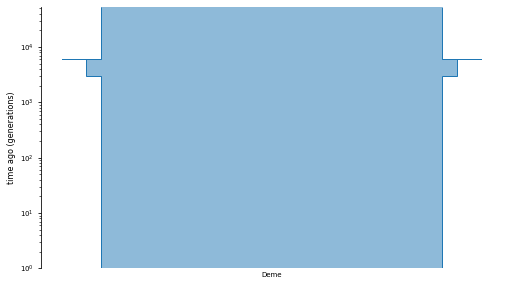

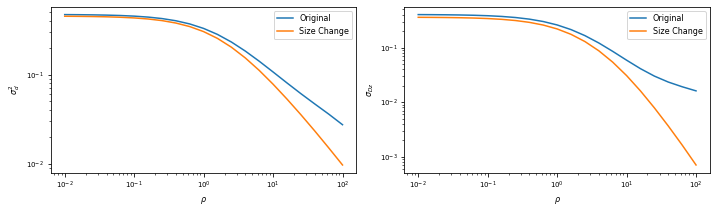

In [14]:
model_iicr, time_iicr, model_sc, model_sliced_LD = run_LD_analysis_from_model_crosspop(IM, pops = ["Merge_1","Deme2"])

In [15]:
command = "./ms " + demes.to_ms(model_sc,N0=N)
command

file1 = open("Model6.IM_cm_crosspop.mscommand", "w")
file1.write(command)
file1.close()

file1 = open("Model6.IM_cm_crosspop.iicr", "w")
file1.write("\t".join(map(str,time_iicr)))
file1.write("\n")
file1.write("\t".join(map(str,model_iicr)))
file1.close()

### Merger with stem migration

In [ ]:
mws = model.load_yaml("merger_with_stem_migration.yaml")

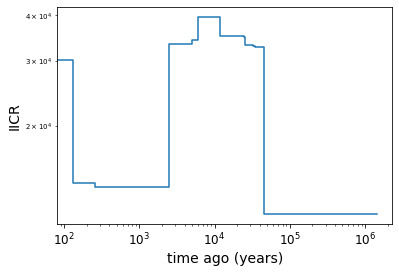

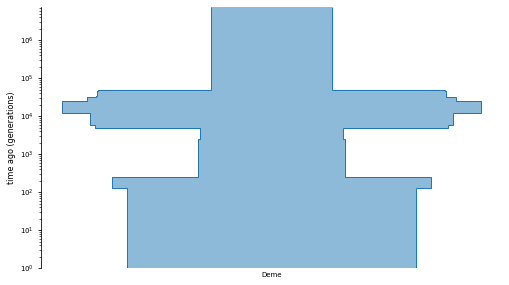

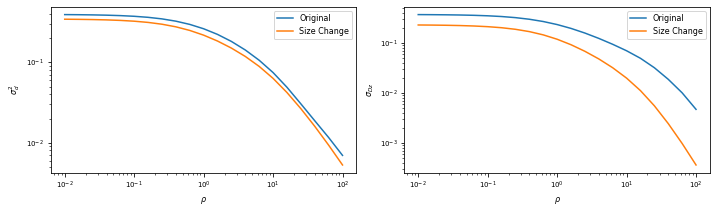

In [ ]:
model_iicr, time_iicr, model_sc, model_sliced_LD = run_LD_analysis_from_model(mws, pop = "MSL")

In [ ]:
command = "./ms " + demes.to_ms(model_sc,N0=N)
command

In [ ]:
file1 = open("Model5.mws_MSL.mscommand", "w")
file1.write(command)
file1.close()

file1 = open("Model5.mws_MSL.iicr", "w")
file1.write("\t".join(map(str,time_iicr)))
file1.write("\n")
file1.write("\t".join(map(str,model_iicr)))
file1.close()